In [1]:
%matplotlib inline

import glob
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import shutil
import skimage.io as io
import tensorflow as tf

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

TRAIN_PATH = 'data/Train/'
TEST_PATH = 'data/Test/'
VALIDATION_PATH = 'data/Validation/'
LOG_PATH = 'data/logs/'

Using TensorFlow backend.


### Dataset Sizes

In [2]:
def set_size_summary(base_dir, subsets=['']):
    num_images = 0
    for subset in subsets:
        for class_folder in os.listdir(base_dir):
            if subset:
                imgs_paths = glob.glob(f'{base_dir}{class_folder}/{subset}/*.ppm')
            else:
                imgs_paths = glob.glob(f'{base_dir}{class_folder}/*.ppm')        
            imgs_count = len(imgs_paths)
            num_images += imgs_count
            print(f'{imgs_count} images of class {class_folder}.')
    print(f'\nTotal number of images: {num_images}')

In [3]:
def plot_sample_paths(base_dir):
    paths = glob.glob(f'{base_dir}**/*.ppm', recursive=True)
    samples = np.random.choice(paths, 3, replace=False)
    fig=plt.figure(figsize=(10, 10))
    for n, sample in enumerate(samples, 1):
        fig.add_subplot(1, 3, n)
        img = plt.imread(sample)
        plt.imshow(img)
    plt.show();

- Training Set

Checking training set class distribution:

In [4]:
!ls {TRAIN_PATH}

A  B  C  Five  Point  V


In [5]:
set_size_summary(TRAIN_PATH)

572 images of class C.
1329 images of class A.
1395 images of class Point.
654 images of class Five.
435 images of class V.
487 images of class B.

Total number of images: 4872


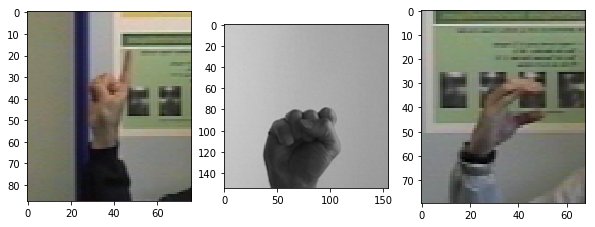

In [6]:
plot_sample_paths(TRAIN_PATH)

- Test Set

And also our test set distribution:

In [7]:
!ls {TEST_PATH}

A  B  C  Five  Point  V


In [8]:
set_size_summary(TEST_PATH, subsets=['complex', 'uniform'])

47 images of class C.
39 images of class A.
54 images of class Point.
58 images of class Five.
38 images of class V.
41 images of class B.
65 images of class C.
58 images of class A.
65 images of class Point.
76 images of class Five.
57 images of class V.
61 images of class B.

Total number of images: 659


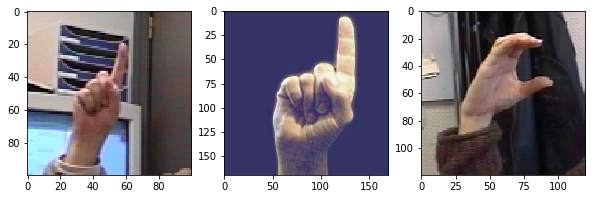

In [9]:
plot_sample_paths(TEST_PATH)

### Create Validation Set

Creating a validation set from training set:

In [10]:
def create_validation_set():
    for class_folder in os.listdir(TRAIN_PATH):
        imgs_paths = glob.glob(f'{TRAIN_PATH}{class_folder}/*.ppm')
        np.random.shuffle(imgs_paths)
        if not os.path.exists(f'{VALIDATION_PATH}'):
            os.mkdir(f'{VALIDATION_PATH}')
        if not os.path.exists(f'{VALIDATION_PATH}{class_folder}/'):
            os.mkdir(f'{VALIDATION_PATH}{class_folder}/')
        for image_path in imgs_paths[:int(len(imgs_paths)*0.2)]:
            shutil.move(image_path, os.path.join(f'{VALIDATION_PATH}{class_folder}', os.path.basename(image_path)))

In [11]:
if not os.path.exists(f'{VALIDATION_PATH}'):
    create_validation_set()    

In [12]:
set_size_summary(TRAIN_PATH)

458 images of class C.
1064 images of class A.
1116 images of class Point.
524 images of class Five.
348 images of class V.
390 images of class B.

Total number of images: 3900


In [13]:
set_size_summary(VALIDATION_PATH)

114 images of class C.
265 images of class A.
279 images of class Point.
130 images of class Five.
87 images of class V.
97 images of class B.

Total number of images: 972


### Balancing Datasets

We should have the same amount of samples of each class to avoid introducing bias in the training process:

In [14]:
def count_samples(base_dir):
    class_size = {}
    for class_folder in os.listdir(base_dir):
        class_size[class_folder] = len(glob.glob(f'{base_dir}{class_folder}/*.ppm'))
    return class_size

In [15]:
sizes = count_samples(TRAIN_PATH)
sizes

{'C': 458, 'A': 1064, 'Point': 1116, 'Five': 524, 'V': 348, 'B': 390}

In [16]:
target_number = max(sizes.values())
target_number

1116

In [17]:
unique_id = 0
for class_folder in os.listdir(TRAIN_PATH):
    imgs_paths = glob.glob(f'{TRAIN_PATH}{class_folder}/*.ppm')
    for _ in range(len(imgs_paths), target_number):
        img = io.imread(np.random.choice(imgs_paths))
        io.imsave(f'{TRAIN_PATH}{class_folder}/artificial-{unique_id}.ppm', img)
        unique_id += 1

In [18]:
count_samples(TRAIN_PATH)

{'C': 1116, 'A': 1116, 'Point': 1116, 'Five': 1116, 'V': 1116, 'B': 1116}

### Image dimensions

Let's find the average dimensions of the images in the dataset so we can resize them with minimum distortions:

In [19]:
def load_collection(dirs):
    imgs = io.ImageCollection(dirs)
    return imgs

In [20]:
train_imgs = load_collection(glob.glob(f'{TRAIN_PATH}/**/*.ppm'))
dims = np.array([[h.shape[0], h.shape[1]] for h in train_imgs])

In [21]:
dims.shape

(6696, 2)

In [22]:
np.mean(dims[:,0]), np.mean(dims[:,1]), np.std(dims[:,0]), np.std(dims[:,1])

(92.706093189964164, 85.45519713261649, 50.28850099226127, 62.660980923837151)

In [23]:
np.max(dims[:,0]), np.min(dims[:,0])

(320, 64)

In [24]:
np.max(dims[:,1]), np.min(dims[:,1])

(384, 56)

In [25]:
mean_h, mean_w = int(np.mean(dims[:,0])), int(np.mean(dims[:,1]))
mean_h, mean_w

(92, 85)

### Data Generators

Then create generators for the data:

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1,
                                   zoom_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(TRAIN_PATH, 
                                              target_size=(mean_h, mean_w),
                                              batch_size=8,
                                              class_mode='categorical')
val_gen = val_datagen.flow_from_directory(VALIDATION_PATH,
                                          target_size=(mean_h, mean_w),
                                          batch_size=8,
                                          class_mode='categorical')

Found 6696 images belonging to 6 classes.
Found 972 images belonging to 6 classes.


### Callbacks

Defining Keras' callbacks:

In [27]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='data/logs', **kwargs):
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [28]:
callback = [
    keras.callbacks.TensorBoard(log_dir=LOG_PATH, write_graph=True, write_images=True),
    TrainValTensorBoard(write_graph=True),
    keras.callbacks.ModelCheckpoint('vanila_conv.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
]

And some ploting functions:

In [29]:
def plot_acc_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [30]:
def plot_loss_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Vanilla ConvNet

In [31]:
small_conv = models.Sequential()

small_conv.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(mean_h, mean_w, 3)))
small_conv.add(layers.MaxPooling2D((2, 2)))
small_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))
small_conv.add(layers.MaxPooling2D((2, 2)))
small_conv.add(layers.Conv2D(128, (3, 3), activation='relu'))
small_conv.add(layers.MaxPooling2D((2, 2)))
small_conv.add(layers.Conv2D(128, (3, 3), activation='relu'))
small_conv.add(layers.MaxPooling2D((2, 2)))
small_conv.add(layers.Flatten())
small_conv.add(layers.Dense(512, activation='relu'))
small_conv.add(layers.Dense(6, activation=K.tf.nn.softmax))

small_conv.compile(loss='categorical_crossentropy', 
                   optimizer=optimizers.RMSprop(lr=1e-4),
                   metrics=['acc'])

In [32]:
history = small_conv.fit_generator(train_gen, epochs=10, validation_data=val_gen, callbacks=callback)

Epoch 1/10
837/837 [==============================] - 155s 185ms/step - loss: 1.4157 - acc: 0.4416 - val_loss: 1.1517 - val_acc: 0.6224
Epoch 2/10
837/837 [==============================] - 157s 188ms/step - loss: 1.0122 - acc: 0.6269 - val_loss: 0.7395 - val_acc: 0.7397
Epoch 3/10
837/837 [==============================] - 157s 187ms/step - loss: 0.7577 - acc: 0.7270 - val_loss: 0.7319 - val_acc: 0.7274
Epoch 4/10
837/837 [==============================] - 154s 184ms/step - loss: 0.6326 - acc: 0.7781 - val_loss: 0.4745 - val_acc: 0.8189
Epoch 5/10
837/837 [==============================] - 164s 196ms/step - loss: 0.5393 - acc: 0.8066 - val_loss: 0.3802 - val_acc: 0.8652
Epoch 6/10
837/837 [==============================] - 152s 181ms/step - loss: 0.5058 - acc: 0.8253 - val_loss: 0.4918 - val_acc: 0.8395
Epoch 7/10
837/837 [==============================] - 152s 181ms/step - loss: 0.4671 - acc: 0.8415 - val_loss: 0.3131 - val_acc: 0.9064
Epoch 8/10
837/837 [============================

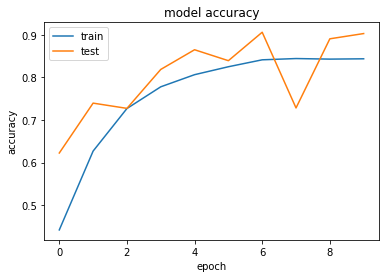

In [33]:
plot_acc_history(history)

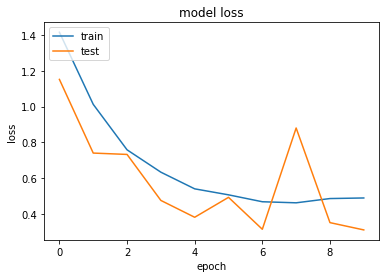

In [34]:
plot_loss_history(history)